# Multi-layer perceptrons

## A simple dataset

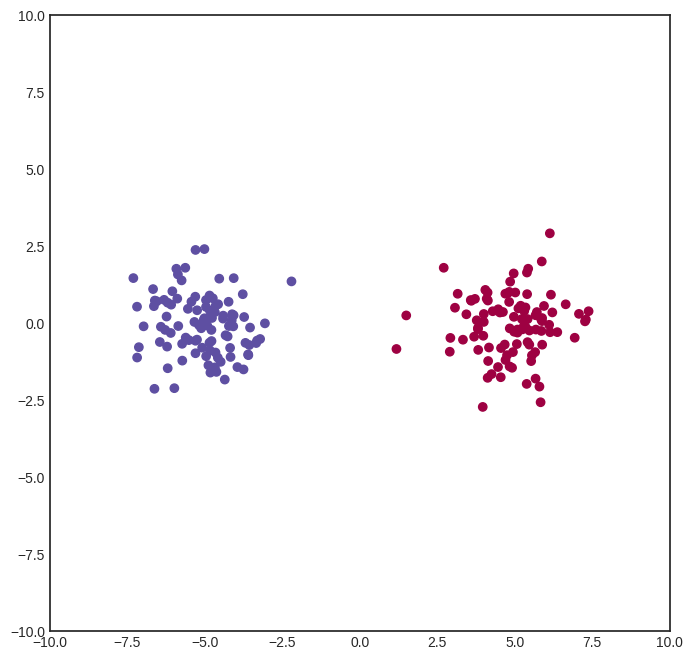

In [2]:
import random
import math
import matplotlib.pyplot as plt


xs = [(random.normalvariate(0, 1) - 5 , random.normalvariate(0, 1)) for _ in range(100)] \
    + [(random.normalvariate(0, 1) + 5 , random.normalvariate(0, 1)) for _ in range(100)]
ys = [1 for _ in range(100)] + [0 for _ in range(100)]

with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 8))
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral)
    plt.show()

In [3]:
from mlfz.nn.scalar import Scalar


class ScalarArray:
    def __init__(self, params):
        self.params = params
        self.n_rows = len(params)
        self.n_cols = len(params[0])

    def __getitem__(self, i):
        return self.params[i]
    
    def __repr__(self):
        return str(self.params)

    def gradient_update(self, lr):
        for row in self.params:
            for p in row:
                p.gradient_update(lr)

    @classmethod
    def from_random(cls, n_rows, n_cols, lower=0, upper=1):
        return ScalarArray(
            [
                [Scalar.from_random(lower, upper) for _ in range(n_cols)]
                for _ in range(n_rows)
            ]
        )
    
    @property
    def value(self):
        return [[p.value for p in row] for row in self.params]

In [4]:
from mlfz.nn import Model
from mlfz.nn.scalar.functional import relu, sigmoid
from itertools import product


class OneLayerPerceptron(Model):
    def __init__(self):
        self.A = ScalarArray.from_random(2, 4)
        self.B = ScalarArray.from_random(4, 1)

    def forward(self, xs):
        """
        Params:
            xs: A list of two scalars.
        """

        fs = [sum([xs[i]*self.A[i][j] for i in range(2)]) for j in range(4)]
        fs_relu = [relu(fs[i]) for i in range(4)]
        gs = sum([fs_relu[i]*self.B[i][0] for i in range(4)])
        y = sigmoid(gs)

        return y

    def parameters(self):
        return {"A": self.A, "B": self.B}
    

In [5]:
from mlfz.nn.scalar.optimizer import GradientDescent


olp = OneLayerPerceptron()

In [6]:
import numpy as np


def visualize_model(model, xs, ys, res=100, xrange=(-10, 10), yrange=(-10, 10)):
    with plt.style.context("seaborn-v0_8-white"):
        plt.figure(figsize=(8, 8))
        
        res = 100
        x = np.linspace(xrange[0], xrange[1], res)
        y = np.linspace(yrange[0], yrange[1], res)
        xx, yy = np.meshgrid(x, y)
        zz = np.zeros_like(xx)
        
        for i, j in product(range(res), range(res)):
            zz[i, j] = model.forward([xx[i, j], yy[i, j]]).value


        # plot the decision boundary
        plt.contourf(xx, yy, zz, levels=100, cmap='coolwarm_r', alpha=0.4)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('the decision boundary of our model')
        
        # plot the data
        plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral, zorder=10)
        plt.show()

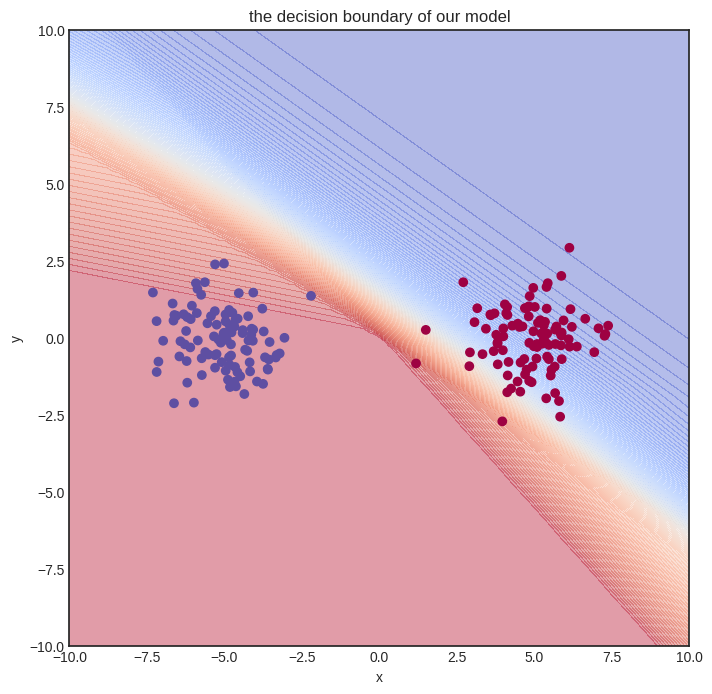

In [7]:
visualize_model(olp, xs, ys)

In [8]:
from mlfz.nn.scalar.loss import binary_cross_entropy


n_steps = 200
lr = 0.1

parameter_list = [olp.parameter_values()]
losses = []

for _ in range(n_steps):
    preds = [olp.forward(x) for x in xs]
    l = binary_cross_entropy(preds, ys)
    l.backward()
    olp.gradient_update(lr)
    parameter_list.append(olp.parameter_values())
    losses.append(l.value)

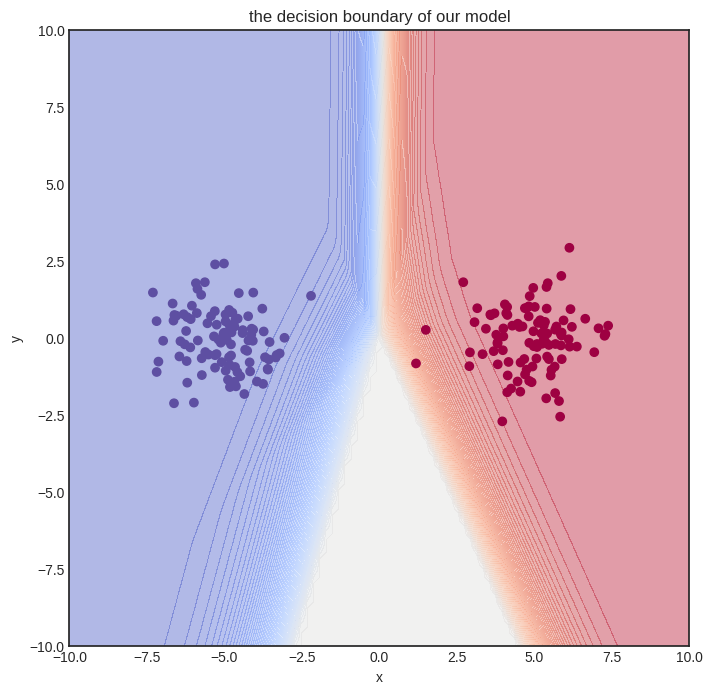

In [9]:
visualize_model(olp, xs, ys)

## A more complex dataset

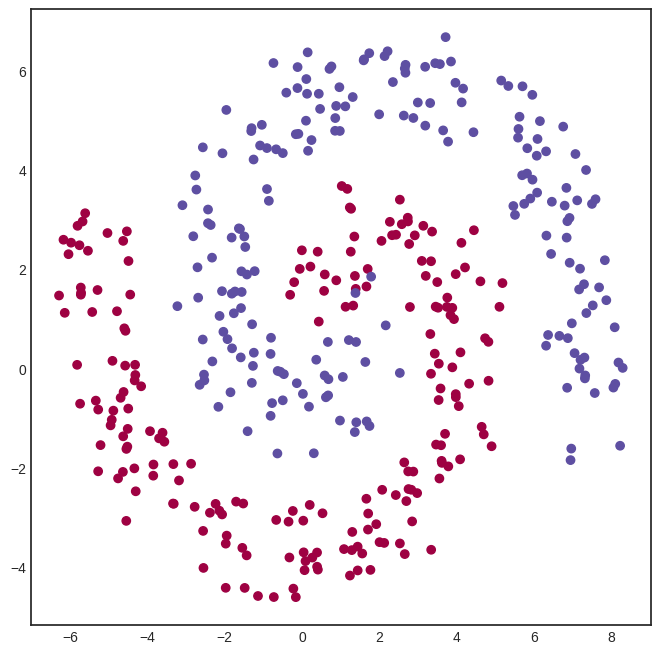

In [10]:
def generate_spiral_dataset(n_points, noise=0.5):
    random_points = [math.sqrt(random.random())*380*2*math.pi/360 for _ in range(n_points)]

    class_1 = [(-math.cos(p) * p + random.random()*noise, math.sin(p) * p + random.random()*noise) for p in random_points]
    class_2 = [(math.cos(p) * p + random.random()*noise, -math.sin(p) * p + random.random()*noise) for p in random_points]

    xs = class_1 + class_2
    ys = [0 for _ in class_1] + [1 for _ in class_2]
    
    return xs, ys

xs, ys = generate_spiral_dataset(200, noise=2)

with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 8))
    plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral)
    plt.show()

In [11]:
from mlfz.nn.scalar.functional import tanh

class MultiLayerPerceptron(Model):
    def __init__(self):
        self.A = ScalarArray.from_random(2, 8)
        self.B = ScalarArray.from_random(8, 8)
        self.C = ScalarArray.from_random(8, 1)

    def forward(self, xs):
        """
        Params:
            xs: A list of two scalars.
        """

        fs = [sum([xs[i]*self.A[i][j] for i in range(2)]) for j in range(8)]
        fs_tanh = [tanh(fs[i]) for i in range(8)]
        gs = [sum([fs_tanh[i]*self.B[i][j] for i in range(8)]) for j in range(8)]
        gs_tanh = [tanh(gs[i]) for i in range(8)]
        hs = sum([gs_tanh[i]*self.C[i][0] for i in range(8)])
        y = sigmoid(hs)

        return y

    def parameters(self):
        return {"A": self.A, "B": self.B, "C": self.C}

In [12]:
mlp = MultiLayerPerceptron()

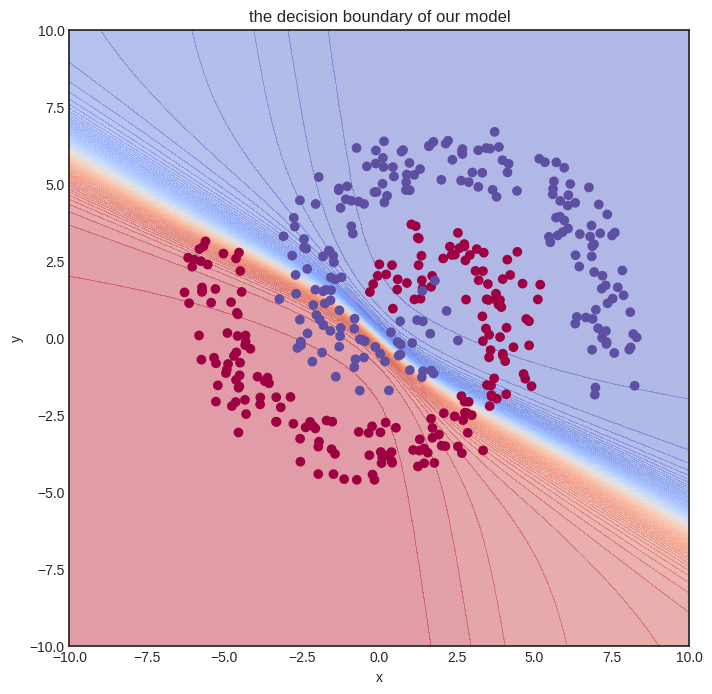

In [13]:
visualize_model(mlp, xs, ys)

In [14]:
n_steps = 1000
lr = 0.1

parameter_list = [mlp.parameter_values()]
losses = []


for i in range(n_steps):
    preds = [mlp.forward(x) for x in xs]
    l = binary_cross_entropy(preds, ys)
    
    print(f"Step no. {i+1}, loss = {l.value}")
    
    l.backward()
    mlp.gradient_update(lr)
    parameter_list.append(mlp.parameter_values())
    losses.append(l.value)

Step no. 1, loss = 1.0669685267467268
Step no. 2, loss = 1.011109994326778
Step no. 3, loss = 0.9620347851488095
Step no. 4, loss = 0.9185934400580992
Step no. 5, loss = 0.8796858582519171
Step no. 6, loss = 0.8444964411325573
Step no. 7, loss = 0.8125024456957297
Step no. 8, loss = 0.7833903594608423
Step no. 9, loss = 0.7569712503206526
Step no. 10, loss = 0.7331189651179557
Step no. 11, loss = 0.711730424397906
Step no. 12, loss = 0.6927022251784254
Step no. 13, loss = 0.6759183521896862
Step no. 14, loss = 0.6612453162884048
Step no. 15, loss = 0.6485322215321568
Step no. 16, loss = 0.6376139819401361
Step no. 17, loss = 0.6283163278845652
Step no. 18, loss = 0.620461525651934
Step no. 19, loss = 0.6138739802759419
Step no. 20, loss = 0.6083851365044181
Step no. 21, loss = 0.6038373313653489
Step no. 22, loss = 0.600086464090381
Step no. 23, loss = 0.5970035161892595
Step no. 24, loss = 0.5944750669320884
Step no. 25, loss = 0.5924030089710612
Step no. 26, loss = 0.5907036848089927

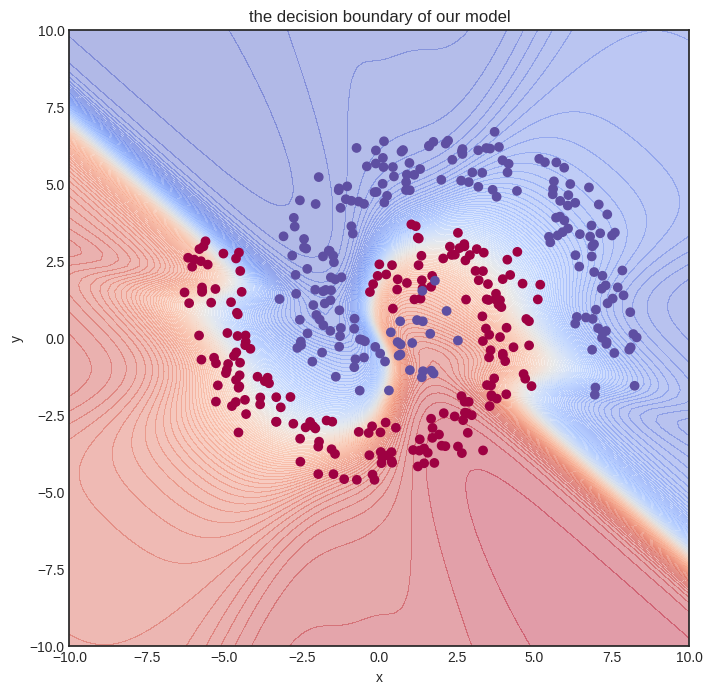

In [15]:
visualize_model(mlp, xs, ys)